# **QML Exercise**: Classification with Quantum & Classical Models
In this exercise, we will explore how Quantum Machine Learning (QML) can be used to solve a complex, two-dimensional classification problem. We will build two types of quantum classifiers and compare their performance against a standard classical model.

\

A major bottleneck in QML can be the time it takes to simulate quantum circuits. To address this, we will leverage **lightning.qubit**, a high-performance CPU simulator provided by PennyLane, to dramatically speed up the computation.

\

**Getting Started**: Installing Libraries
First, we need to install the necessary Python libraries. This code block will install PennyLane for quantum programming, Scikit-learn for classical machine learning tools, Matplotlib for plotting, and tqdm for progress bars.

In [ ]:
!pip install pennylane --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install tqdm --quiet
!pip install ipywidgets --quiet

# **A Quick Primer on Quantum Circuits**
Before we apply quantum computing to machine learning, let's understand the basics of building a quantum circuit.

A **quantum circuit** is a sequence of operations, called **quantum gates**, applied to qubits.

* **Qubits**: These are the basic units of quantum information. Unlike classical bits that are either 0 or 1, a qubit can exist in a **superposition** of both states simultaneously.

* **Quantum Gates**: These are operations that manipulate the state of the qubits. For example, a Hadamard gate puts a qubit into a superposition, and a CNOT gate entangles two qubits.

* **Measurement**: At the end of a circuit, we measure the qubits, which collapses their superposition into a classical state (either 0 or 1).

\

**Building a Simple Circuit in PennyLane**

Let's build a simple two-qubit circuit that creates an entangled state known as a Bell state.

* **Define a Device**: A device is the "backend" that will run our circuit. It can be a quantum simulator (like default.qubit) or a real quantum computer.

* **Create a QNode**: A QNode is a quantum circuit bound to a specific device. We define it in Python using the @qml.qnode decorator.

* **Define the Circuit**: Inside our QNode function, we define the sequence of gates.

* **Return a Measurement**: The function must return a classical measurement result.

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
import time

# 1. Define a device (a 2-qubit simulator)
dev_simple = qml.device("default.qubit", wires=2)

# 2. Create a QNode bound to the device
@qml.qnode(dev_simple)
def simple_bell_state_circuit():
    """
    This quantum circuit creates a Bell state by applying a
    Hadamard gate and a CNOT gate.
    """
    # 3. Apply gates
    qml.Hadamard(wires=0)  # Puts the first qubit in a superposition
    qml.CNOT(wires=[0, 1])   # Entangles the two qubits

    # 4. Return a measurement (in this case, the state probabilities)
    return qml.probs(wires=[0, 1])

# Run the circuit
result = simple_bell_state_circuit()
print(f"Output probabilities: {result}")
print("This indicates a 50% chance of measuring |00> and a 50% chance of measuring |11>.")


Output probabilities: [0.5 0.  0.  0.5]
This indicates a 50% chance of measuring |00> and a 50% chance of measuring |11>.


**Visualizing the Circuit**

PennyLane makes it easy to visualize what we've just built. We can get both a graphical representation and a text-based one.

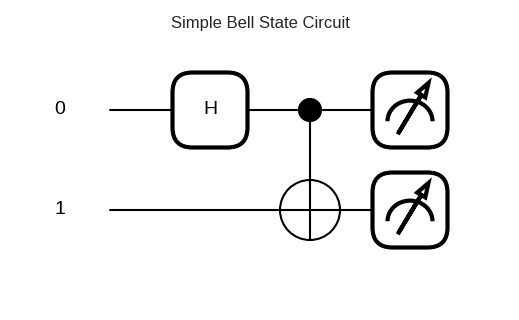


Circuit Diagram (Text):
0: ──H─╭●─┤ ╭Probs
1: ────╰X─┤ ╰Probs


In [ ]:
# Draw the circuit graphically
fig, ax = qml.draw_mpl(simple_bell_state_circuit)()
fig.suptitle("Simple Bell State Circuit")
plt.show()

# You can also get a text-based drawing
print("\nCircuit Diagram (Text):")
print(qml.draw(simple_bell_state_circuit)())


This simple example shows the fundamental workflow of creating and running a quantum circuit. The machine learning models we build next will use these same principles but with more complex circuits.

# **Conceptual Overview for Beginners**
Before we get into the code, let's break down some of the key concepts for those new to machine learning or quantum computing.

\

**What is a Support Vector Machine (SVM)?**

A **Support Vector Machine (SVM)** is a powerful and popular supervised machine learning algorithm used for classification tasks. Imagine you have a dataset with two categories of points on a graph. The goal of an SVM is to find the best possible line (or hyperplane in higher dimensions) that separates these two categories. This line is called the "decision boundary". The "best" line is the one that is as far away as possible from the closest points in each category. These closest points are called "support vectors," which give the SVM its name.

\

**What is a Kernel?**

Sometimes, data isn't easily separable by a straight line. This is where kernels come in. A kernel is a mathematical function that takes the original, non-separable data and transforms it into a higher-dimensional space where it becomes linearly separable. This is often called the "kernel trick." Think of it as adding a new dimension to your data to make it easier to draw a dividing line. The function that performs this transformation is the kernel.

\

**What is a Quantum Support Vector Machine (QSVM)?**

A **Quantum Support Vector Machine (QSVM)** gives the concept of a kernel a quantum twist. Instead of using a classical mathematical function as a kernel, a QSVM uses a quantum circuit to transform the data. This quantum circuit, also known as a "feature map," encodes the classical data into a quantum state. By doing this, we can explore a much larger and more complex feature space than what is available to classical computers. The hope is that this quantum-enhanced feature space will allow us to find better decision boundaries for our classification problems.

# **Part 1: Generating the 2D "Two Moons" Data**

We will start by generating a "two moons" dataset using Scikit-learn. This dataset is a classic example of a problem where the two classes are not linearly separable, meaning you can't draw a single straight line to separate them perfectly. This makes it an interesting challenge for our models.


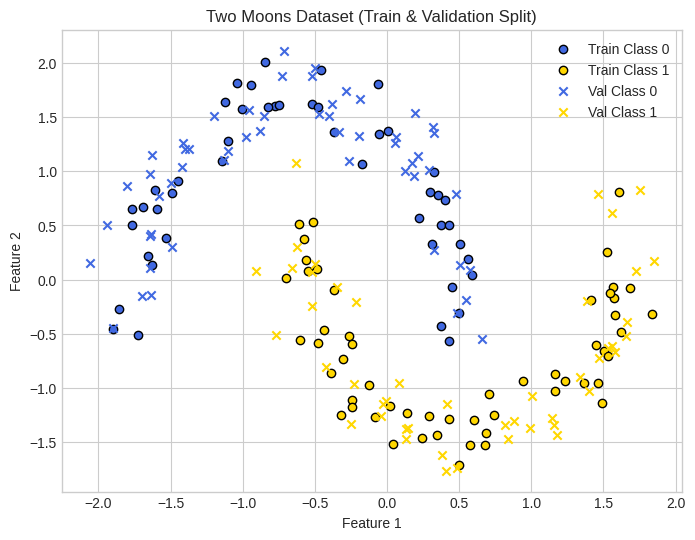

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time

X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Plot the data to see the challenge
plt.figure(figsize=(8, 6))

# --- Plot Training Data (Circles) ---
# Plot class 0 training points
plt.scatter(
    X_train_scaled[y_train == 0, 0],
    X_train_scaled[y_train == 0, 1],
    c="royalblue", marker="o", edgecolors="k", label="Train Class 0"
)
# Plot class 1 training points
plt.scatter(
    X_train_scaled[y_train == 1, 0],
    X_train_scaled[y_train == 1, 1],
    c="gold", marker="o", edgecolors="k", label="Train Class 1"
)

# --- Plot Validation Data (X's) ---
# Plot class 0 validation points
plt.scatter(
    X_val_scaled[y_val == 0, 0],
    X_val_scaled[y_val == 0, 1],
    c="royalblue", marker="x", label="Val Class 0"
)
# Plot class 1 validation points
plt.scatter(
    X_val_scaled[y_val == 1, 0],
    X_val_scaled[y_val == 1, 1],
    c="gold", marker="x", label="Val Class 1"
)


plt.title("Two Moons Dataset (Train & Validation Split)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# **Part 2: Building and Training the QSVM**

This is where we define our quantum kernel. We specify **lightning.qubit** as our device, which uses a highly optimized C++ backend to run simulations much faster than the default Python-based simulator.

\

**Defining the Quantum Kernel**

The kernel is created by a quantum circuit that encodes the data points. The similarity between two data points **x1** and **x2** is calculated by running the feature map for **x1**, followed by the inverse of the feature map for **x2**, and then measuring the probability of the qubits returning to the all-zero state.

In [ ]:
# --- 2. Define an Improved Quantum Kernel ---
num_qubits = 2
dev = qml.device("lightning.qubit", wires=num_qubits)

def feature_map(x):
    """
    A more expressive feature map (the ansatz).
    Have a look at https://pennylane.ai/qml/glossary/quantum_feature_map for details and references
    This circuit encodes the data and adds entanglement.
    """
    qml.AngleEmbedding(x, wires=range(num_qubits))
    qml.H(wires=0)
    qml.H(wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RZ(x[0], wires=0)
    qml.RZ(x[1], wires=1)
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    #qml.CNOT(wires=[0, 1])
    #qml.RY(x[0], wires=0)
    #qml.RY(x[1], wires=1)

# Define the quantum circuit that will be our feature map
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    """The quantum circuit that uses the feature map."""
    # Apply the feature map for the first data point
    feature_map(x1)
    # Apply the inverse of the feature map for the second data point
    qml.adjoint(feature_map)(x2)
    # Return the probability of being in the all-zero state
    return qml.probs(wires=range(num_qubits))

def quantum_kernel(X1, X2):
    """The quantum kernel function that uses the circuit."""
    # The kernel is the probability of measuring the all-zero state
    # We add a tqdm progress bar to the outer loop
    return np.array([[kernel_circuit(x1, x2)[0] for x2 in X2] for x1 in tqdm(X1, desc="Kernel Rows")])

**Visualizing the QSVM Kernel Circuit**

Let's draw the circuit to see what it looks like. We'll pass in some dummy data to render the circuit diagram.

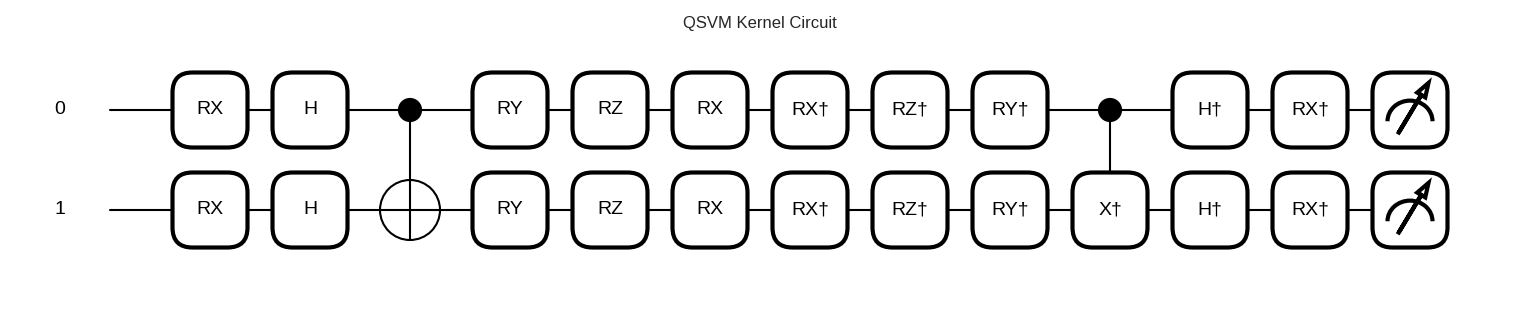

QSVM Kernel Circuit (Text):
0: ──RX(0.50)──H─╭●──RY(0.50)──RZ(0.50)──RX(0.50)──RX(-0.20)†──RZ(-0.20)†──RY(-0.20)†─╭X†──H† ···
1: ──RX(0.30)──H─╰X──RY(0.30)──RZ(0.30)──RX(0.30)──RX(0.70)†───RZ(0.70)†───RY(0.70)†──╰X†──H† ···

0: ··· ──RX(-0.20)†─┤ ╭Probs
1: ··· ──RX(0.70)†──┤ ╰Probs


In [ ]:
# Create some dummy data points to draw the circuit
dummy_x1 = np.array([0.5, 0.3])
dummy_x2 = np.array([-0.2, 0.7])

# Draw the kernel circuit
fig, ax = qml.draw_mpl(kernel_circuit)(dummy_x1, dummy_x2)
fig.suptitle("QSVM Kernel Circuit")
plt.show()

# You can also get a text-based drawing
print("QSVM Kernel Circuit (Text):")
print(qml.draw(kernel_circuit)(dummy_x1, dummy_x2))

**Lets Visualize the Quantum Kernel Matrix,**

**A "Good" Kernel (Clear Separation)**:

* You should see two bright yellow squares along the main diagonal.

*  The rest of the matrix should be dark purple/blue.

*  This "block-diagonal" structure is the ideal result. It means your feature map is successfully making points from the same class have high similarity (the yellow blocks) and points from different classes have low similarity (the dark regions). This makes the data very easy for the SVM to separate.



Calculating and visualizing the quantum kernel matrix for the training data...


Kernel Rows:   0%|          | 0/100 [00:00<?, ?it/s]

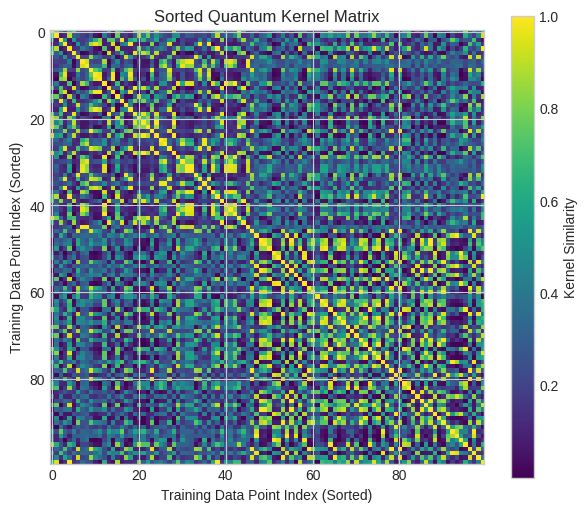

In [ ]:
# --- Visualize the Quantum Kernel Matrix ---
print("\nCalculating and visualizing the quantum kernel matrix for the training data...")

kernel_matrix = quantum_kernel(X_train_scaled, X_train_scaled)
sort_indices = np.argsort(y_train)
X_sorted = X_train_scaled[sort_indices]
y_sorted = y_train[sort_indices]
kernel_matrix_sorted = kernel_matrix[np.ix_(sort_indices, sort_indices)]

plt.figure(figsize=(7, 6))
plt.imshow(
    kernel_matrix_sorted,
    interpolation="nearest",
    cmap="viridis",
)
plt.colorbar(label="Kernel Similarity")
plt.title("Sorted Quantum Kernel Matrix")
plt.xlabel("Training Data Point Index (Sorted)")
plt.ylabel("Training Data Point Index (Sorted)")
plt.show()

**Training the QSVM and Classical SVM**

Now we train both the QSVM and a classical SVM with a standard Radial Basis Function (RBF) kernel. This will allow us to directly compare the performance of the quantum kernel against a powerful classical alternative.

In [ ]:
# --- Train the QSVM Classifier ---
print("Calculating the improved quantum kernel matrix...")
# The 'precomputed' kernel tells the SVM to use our custom quantum kernel
qsvm_classifier = SVC(kernel=quantum_kernel)
qsvm_classifier.fit(X_train_scaled, y_train)
print("QSVM training complete.")

# --- 3. Train the Classical SVM Classifier ---
print("\nTraining the classical SVM classifier...")
svm_classifier = SVC(kernel="rbf", gamma=0.5, C=1.0)
#look at this link to understand what the rbf kernal is doing:
#https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a/
svm_classifier.fit(X_train_scaled, y_train)
print("SVM training complete.")

Calculating the improved quantum kernel matrix...


Kernel Rows:   0%|          | 0/100 [00:00<?, ?it/s]

QSVM training complete.

Training the classical SVM classifier...
SVM training complete.


# **Part 3: Building a Variational Quantum Classifier (VQC)**
Now we'll build a different kind of quantum model.

**What is a Variational Quantum Classifier (VQC)?**

A **Variational Quantum Classifier (VQC)** is another type of quantum machine learning model. Instead of using a quantum circuit as a kernel for a classical SVM, a VQC uses a "parameterized" quantum circuit as the core of the classifier itself.

Here's a simple breakdown of how it works:

* **Data Encoding**: We first encode our classical data into a quantum state.

* **Variational Circuit**: This is the heart of the VQC. It's a quantum circuit with adjustable parameters (or "weights"). We can think of these as knobs we can turn to change the behavior of the circuit.

* **Measurement**: After the data is processed by the variational circuit, we measure one of the qubits. The outcome of this measurement is used to make a prediction (e.g., class "0" or "1").

* **Training**: We use a classical optimizer to "tune" the parameters of our variational circuit. The optimizer's goal is to find the set of parameters that minimizes a "cost function," which measures how many mistakes the classifier is making.

In essence, a VQC is a hybrid quantum-classical algorithm where a quantum computer performs the classification and a classical computer optimizes the quantum circuit.

**Defining the VQC Circuit**

The VQC consists of layers of gates with trainable weights. The input data is first encoded, and then it passes through these trainable layers before a final measurement is made.

**Visualizing the VQC Circuit**

Let's draw the VQC circuit. Since it has many layers, the diagram will be quite large, but it clearly shows the structure of data encoding followed by trainable layers.

In [ ]:
num_qubits = 2
num_layers = 4
dev = qml.device("lightning.qubit", wires=num_qubits)

def layer(W):
    qml.H(wires=0)
    qml.H(wires=1)
    qml.RY(W[0], wires=0)
    qml.RY(W[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(W[2], wires=0)
    qml.RY(W[3], wires=1)

@qml.qnode(dev)
def circuit(weights, x):
    qml.AngleEmbedding(x, wires=range(num_qubits))
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def binary_cross_entropy_loss(labels, predictions_prob):
    predictions_prob = np.clip(predictions_prob, 1e-7, 1 - 1e-7)
    return -np.mean(labels * np.log(predictions_prob) + (1 - labels) * np.log(1 - predictions_prob))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(weights, bias, X, Y):
    logits = np.array([variational_classifier(weights, bias, x) for x in X])
    probabilities = sigmoid(logits)
    return binary_cross_entropy_loss(Y, probabilities)

def accuracy(weights, bias, X, Y):
    logits = np.array([variational_classifier(weights, bias, x) for x in X])
    probabilities = sigmoid(logits)
    predicted_labels = (probabilities > 0.5).astype(int)
    return np.sum(predicted_labels == Y) / len(Y)


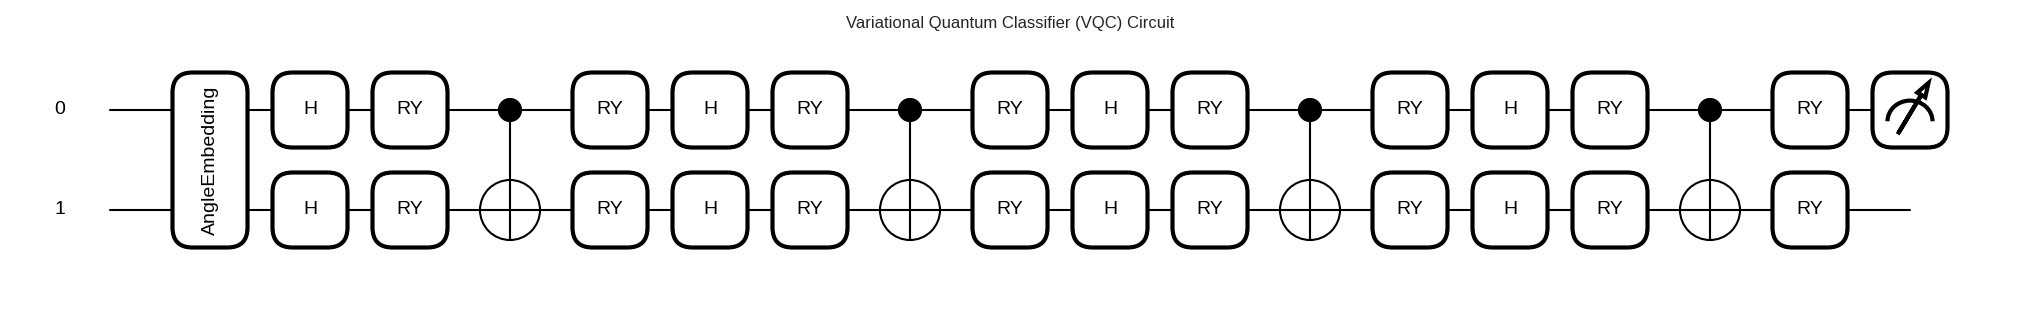

In [ ]:
# Create dummy weights and a data point to draw the circuit
dummy_weights = np.random.uniform(0, 2 * np.pi, size=(num_layers, 4))
dummy_x = np.array([0.5, 0.3])

# Draw the VQC circuit
fig, ax = qml.draw_mpl(circuit)(dummy_weights, dummy_x)
fig.suptitle("Variational Quantum Classifier (VQC) Circuit")
plt.show()

# You can also get a text-based drawing
#print("VQC Circuit (Text):")
#print(qml.draw(vqc_circuit)(dummy_weights, dummy_x))

**Training the VQC**

We train the VQC by minimizing a cost function (square loss) using a classical optimizer. The optimizer iteratively updates the circuit's weights to improve its accuracy.

In [ ]:
# Initialize parameters.
np.random.seed(1)
weights = np.random.uniform(0, 2 * np.pi, size=(num_layers, 4), requires_grad=True)
bias = np.array(0.0, requires_grad=True)

# Set up optimizer and training parameters.
optimizer = qml.AdamOptimizer(0.1)
batch_size = 10
training_steps = 100

# --- Training Loop ---
print("Training the VQC...")
train_costs = []
val_accuracies = []

for i in tqdm(range(training_steps), desc="VQC Training"):
    batch_index = np.random.randint(0, len(X_train_scaled), (batch_size,))
    X_batch = X_train_scaled[batch_index]
    y_batch = y_train[batch_index]

    # --- THIS IS THE KEY CHANGE ---
    # We call step_and_cost by passing the cost function and its arguments directly.
    # PennyLane automatically finds the trainable parameters (weights, bias).
    (weights, bias), cost_val = optimizer.step_and_cost(cost, weights, bias, X=X_batch, Y=y_batch)

    train_costs.append(cost_val)

    if (i + 1) % 5 == 0:
        val_acc = accuracy(weights, bias, X_val_scaled, y_val)
        val_accuracies.append(val_acc)
        print(f"Iter: {i+1:3d} | Cost: {cost_val:0.7f} | Validation Accuracy: {val_acc:0.4f}")


print("\nTraining complete.")
final_train_accuracy = accuracy(weights, bias, X_train_scaled, y_train)
final_val_accuracy = accuracy(weights, bias, X_val_scaled, y_val)

print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Training the VQC...


VQC Training:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   5 | Cost: 0.6362701 | Validation Accuracy: 0.5100
Iter:  10 | Cost: 0.7978248 | Validation Accuracy: 0.5100
Iter:  15 | Cost: 0.6251194 | Validation Accuracy: 0.5300
Iter:  20 | Cost: 0.7241309 | Validation Accuracy: 0.5500
Iter:  25 | Cost: 0.6213281 | Validation Accuracy: 0.5300
Iter:  30 | Cost: 0.7280199 | Validation Accuracy: 0.4900
Iter:  35 | Cost: 0.6469440 | Validation Accuracy: 0.5300
Iter:  40 | Cost: 0.6564916 | Validation Accuracy: 0.5700
Iter:  45 | Cost: 0.6666654 | Validation Accuracy: 0.5300
Iter:  50 | Cost: 0.7143594 | Validation Accuracy: 0.5600
Iter:  55 | Cost: 0.6764988 | Validation Accuracy: 0.5600
Iter:  60 | Cost: 0.5989956 | Validation Accuracy: 0.5500
Iter:  65 | Cost: 0.6661660 | Validation Accuracy: 0.5400
Iter:  70 | Cost: 0.7245033 | Validation Accuracy: 0.5300
Iter:  75 | Cost: 0.6793176 | Validation Accuracy: 0.5600
Iter:  80 | Cost: 0.6299336 | Validation Accuracy: 0.5600
Iter:  85 | Cost: 0.7014404 | Validation Accuracy: 0.5200
Iter:  90 | Co

# **Part 4: Visualize and Compare All Results**
Finally, we'll calculate the accuracy of all three models and plot their decision boundaries to visually compare how they classified the data.

**Calculating Predictions and Accuracy**

Here we generate predictions for a grid of points to visualize the decision boundaries.

In [ ]:
# --- Calculate QSVM Results ---
print("\nPredicting with QSVM...")
grid_resolution_qsvm = 0.2

# Score the model on the unseen validation data
qsvm_accuracy = qsvm_classifier.score(X_val_scaled, y_val)

# Define plot boundaries based on the training data
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5

# Create the prediction grid
xx_qsvm, yy_qsvm = np.meshgrid(np.arange(x_min, x_max, grid_resolution_qsvm), np.arange(y_min, y_max, grid_resolution_qsvm))
grid_points_qsvm = np.c_[xx_qsvm.ravel(), yy_qsvm.ravel()]
qsvm_predictions_grid = qsvm_classifier.predict(grid_points_qsvm)
Z_qsvm = qsvm_predictions_grid.reshape(xx_qsvm.shape)


Predicting with QSVM...


Kernel Rows:   0%|          | 0/100 [00:00<?, ?it/s]

Kernel Rows:   0%|          | 0/576 [00:00<?, ?it/s]

In [ ]:
# --- Calculate Classical SVM Results ---
print("\nPredicting with Classical SVM...")
grid_resolution_svm = 0.2

# Score the model on the unseen validation data
svm_accuracy = svm_classifier.score(X_val_scaled, y_val)

# Define plot boundaries based on the training data
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5

# Create the prediction grid
xx_svm, yy_svm = np.meshgrid(np.arange(x_min, x_max, grid_resolution_svm), np.arange(y_min, y_max, grid_resolution_svm))
grid_points_svm = np.c_[xx_svm.ravel(), yy_svm.ravel()]
svm_predictions_grid = svm_classifier.predict(grid_points_svm)
Z_svm = svm_predictions_grid.reshape(xx_svm.shape)


Predicting with Classical SVM...


In [ ]:
# --- Calculate VQC Results ---
print("\nPredicting with VQC...")
grid_resolution_vqc = 0.2

# Calculate accuracy on the validation set using our defined function
vqc_accuracy = accuracy(weights, bias, X_val_scaled, y_val)

# Define plot boundaries based on the training data
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5

# Create the prediction grid
xx_vqc, yy_vqc = np.meshgrid(np.arange(x_min, x_max, grid_resolution_vqc), np.arange(y_min, y_max, grid_resolution_vqc))
grid_points_vqc = np.c_[xx_vqc.ravel(), yy_vqc.ravel()]
vqc_predictions_grid = np.array([np.sign(variational_classifier(weights, bias, p)) for p in tqdm(grid_points_vqc, desc="VQC Grid")]).reshape(xx_vqc.shape)



Predicting with VQC...


VQC Grid:   0%|          | 0/576 [00:00<?, ?it/s]

**Plotting the Decision Boundaries**

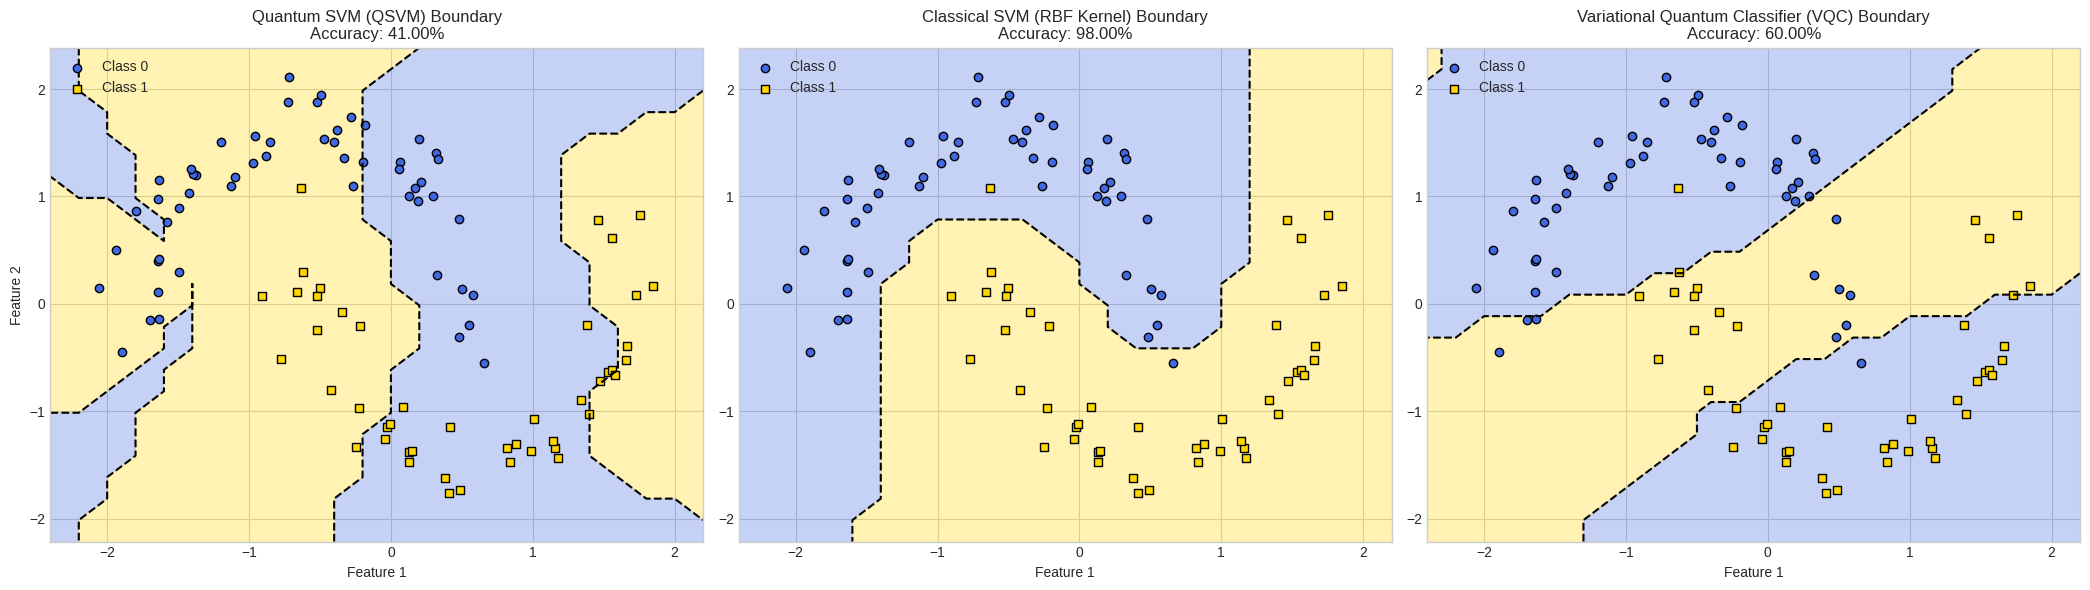


QSVM Accuracy: 0.4100
VQC Accuracy: 0.6000
Classical SVM Accuracy: 0.9800


In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# --- Plot QSVM Results ---
# The decision boundary (Z_qsvm) and scatter points (y_val) are already on the same {-1, 1} scale.
ax1.contourf(xx_qsvm, yy_qsvm, Z_qsvm, levels=[-1, 0, 1], alpha=0.3, colors=["royalblue", "gold"])
ax1.contour(xx_qsvm, yy_qsvm, Z_qsvm, levels=[0], colors="black", linestyles="--")
# Plot validation data points
ax1.scatter(X_val_scaled[y_val == 0, 0], X_val_scaled[y_val == 0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax1.scatter(X_val_scaled[y_val == 1, 0], X_val_scaled[y_val == 1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax1.set_title(f"Quantum SVM (QSVM) Boundary\nAccuracy: {qsvm_accuracy:.2%}")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.legend(loc="upper left")


# --- Plot Classical SVM Results ---
# The decision boundary (Z_svm) and scatter points (y_val) are already on the same {-1, 1} scale.
ax2.contourf(xx_svm, yy_svm, Z_svm, levels=[-1, 0, 1], alpha=0.3, colors=["royalblue", "gold"])
ax2.contour(xx_svm, yy_svm, Z_svm, levels=[0], colors="black", linestyles="--")
# Plot validation data points
ax2.scatter(X_val_scaled[y_val == 0, 0], X_val_scaled[y_val == 0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax2.scatter(X_val_scaled[y_val == 1, 0], X_val_scaled[y_val == 1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax2.set_title(f"Classical SVM (RBF Kernel) Boundary\nAccuracy: {svm_accuracy:.2%}")
ax2.set_xlabel("Feature 1")
ax2.legend(loc="upper left")


# --- Plot VQC Results ---
# The VQC plot is already correct, so no change is needed here.
ax3.contourf(xx_vqc, yy_vqc, vqc_predictions_grid, levels=[-1, 0, 1], alpha=0.3, colors=["royalblue", "gold"])
ax3.contour(xx_vqc, yy_vqc, vqc_predictions_grid, levels=[0], colors="black", linestyles="--")
# Plot validation data points
ax3.scatter(X_val_scaled[y_val == 0, 0], X_val_scaled[y_val == 0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax3.scatter(X_val_scaled[y_val == 1, 0], X_val_scaled[y_val == 1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax3.set_title(f"Variational Quantum Classifier (VQC) Boundary\nAccuracy: {vqc_accuracy:.2%}")
ax3.set_xlabel("Feature 1")
ax3.legend(loc="upper left")


plt.tight_layout()
plt.show()

print(f"\nQSVM Accuracy: {qsvm_accuracy:.4f}")
print(f"VQC Accuracy: {vqc_accuracy:.4f}")
print(f"Classical SVM Accuracy: {svm_accuracy:.4f}")